In [1]:
# IMPORTS
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.linalg
import torch
import time
from tqdm import trange
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

# PATH
import sys
sys.path.append('../../')
from sci.lib.loader import *
from sci.lib.recorder import * 
from sci.lib.utils import *

from sci.lib.seq.helper import *
from sci.lib.seq.models import *
from sci.lib.seq.parser import *

from sci.lib.vis.modes import *
from sci.lib.vis.post import *
from sci.lib.vis.reconstruct import *

# SETTINGS
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size':20})
DPI = 60

#GLOBALS
EE_DIR = '../data/EulerEqs.npz'

# Data

## Data Loading

In [2]:
npzdata = np.load(EE_DIR)
param = 50
rho, u, E, x, params, t = npzdata['arr_0'], npzdata['arr_1'], npzdata['arr_2'], npzdata['arr_3'], npzdata['arr_4'], npzdata['arr_5']
ee = np.array([rho[:,:,param], u[:,:,param], E[:,:,param]])
shape = ee.shape
print('Data Shape: {}'.format(ee.shape))

Data Shape: (3, 500, 626)


## Data Visualization

In [3]:
def ee_plot(ee_t):
    plt.figure(figsize=(10, 6), dpi=80)
    plt.subplot(131)
    plt.plot(x, ee[0,:,ee_t], 'k')
    plt.title('Density $\\rho$')

    plt.subplot(132)
    plt.plot(x, ee[1,:,ee_t], 'k')
    plt.title('Velocty $u$')

    plt.subplot(133)
    plt.plot(x, ee[2,:,ee_t], 'k')
    plt.title('Energy $E$')

interact_manual(ee_plot, ee_t = widgets.IntSlider(value=100,
                                               min=0,
                                               max=shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=100, description='ee_t', max=625), Button(description='Run Interact', st…

<function __main__.ee_plot(ee_t)>

## Proper Orthogonal Decomposition

### Method

In [4]:
def POD3(U, s_ind, e_ind, modes):
    """ Computes the spatial modes and temporal coefficients using the POD """

    # density in x
    S_ux = U[0,:, s_ind:e_ind]
    S_ux = np.moveaxis(S_ux,[0, 1], [1, 0])

    # velocity in x
    S_uy = U[1,:, s_ind:e_ind]
    S_uy = np.moveaxis(S_uy, [0, 1], [1, 0])
    
    # velocity in x
    S_uz = U[2,:, s_ind:e_ind]
    S_uz = np.moveaxis(S_uz, [0, 1], [1, 0])

    # taking the temporal mean of snapshots
    S_uxm = np.mean(S_ux, axis=0)[np.newaxis, ...]
    S_uym = np.mean(S_uy, axis=0)[np.newaxis, ...]
    S_uzm = np.mean(S_uy, axis=0)[np.newaxis, ...]

    # fluctuating components: taking U-Um
    Ux = S_ux - S_uxm
    Uy = S_uy - S_uym
    Uz = S_uz-S_uzm
        
    # return copies
    Uxr = np.copy(Ux)
    Uyr = np.copy(Uy)
    Uzr = np.copy(Uz)

    # Reshaping to create snapshot matrix Y
    Y = np.hstack((Ux, Uy, Uz))

    # Snapshot Method:
    Cs = np.matmul(Y, Y.T)    

    # L:eigvals, As:eigvecs
    Lv, As = scipy.linalg.eigh(Cs)

    # descending order
    Lv = Lv[Lv.shape[0]::-1]
    As = As[:, Lv.shape[0]::-1]

    spatial_modes = np.matmul(Y.T, As[:, :modes]) / np.sqrt(Lv[:modes])    
    temporal_coefficients = np.matmul(Y, spatial_modes)  

    return spatial_modes, temporal_coefficients, Lv, Uxr, Uyr, Uzr

### Reduced VKS Data

From $t=0$ to $t=621$

In [5]:
s_ind = 0
e_ind = shape[2]
pod_modes = 20
spatial_modes, data, eigenvalues, rho_MS, v_MS, e_MS = POD3(ee, s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data.shape))

REDUCED MODEL SHAPE: (626, 20)


### Visualization of Reduced Data

In [6]:
pod_true = np.matmul(data, spatial_modes.T)
pod_rho = pod_true[:, :shape[1]]
pod_v = pod_true[:, shape[1]:2*shape[1]]
pod_E = pod_true[:, 2*shape[1]:]

### Mean Subtracted Difference

In [7]:
def ee_Reconstructed(ee_t):
    plt.figure(figsize=(10,10), tight_layout=True)

    plt.subplot(321)
    plt.plot(x,ee[0,:,ee_t])
    plt.title('True  $\\rho$')

    plt.subplot(322)
    plt.plot(x,rho_MS[ee_t,:])
    plt.title('Mean Subtracted $\\rho$')

    plt.subplot(323)
    plt.plot(x,ee[1,:,ee_t])
    plt.title('True  $v$')

    plt.subplot(324)
    plt.plot(x,v_MS[ee_t,:])
    plt.title('Mean Subtracted $v$')

    plt.subplot(325)
    plt.plot(x,ee[2,:,ee_t])
    plt.title('True  $E$')

    plt.subplot(326)
    plt.plot(x,e_MS[ee_t,:])
    plt.title('Mean Subtracted $E$')


interact_manual(ee_Reconstructed, ee_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='ee_t', max=625), Button(description='Run Interact', styl…

<function __main__.ee_Reconstructed(ee_t)>

### Mean Subtracted FOM vs ROM

In [8]:
def ee_fullReduced(ee_t):

    plt.figure(figsize=(10,10), tight_layout=True)
    plt.subplot(321)
    plt.plot(x,rho_MS[ee_t,:])
    plt.title('FOM $\\rho$')
    plt.subplot(322)
    plt.plot(x,pod_rho[ee_t,:])
    plt.title('ROM $\\rho$')
    plt.subplot(323)
    plt.plot(x,v_MS[ee_t,:])
    plt.title('FOM $v$')
    plt.subplot(324)
    plt.plot(x,pod_v[ee_t,:])
    plt.title('ROM $v$')
    plt.subplot(325)
    plt.plot(x,e_MS[ee_t,:])
    plt.title('FOM $E$')
    plt.subplot(326)
    plt.plot(x,pod_E[ee_t,:])
    plt.title('ROM $E$')

interact_manual(ee_fullReduced, ee_t = widgets.IntSlider(value=100,
                                               min=0,
                                               max=shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=100, description='ee_t', max=625), Button(description='Run Interact', st…

<function __main__.ee_fullReduced(ee_t)>

### Animation FOM v ROM

MovieWriter PillowWriter unavailable; using Pillow instead.


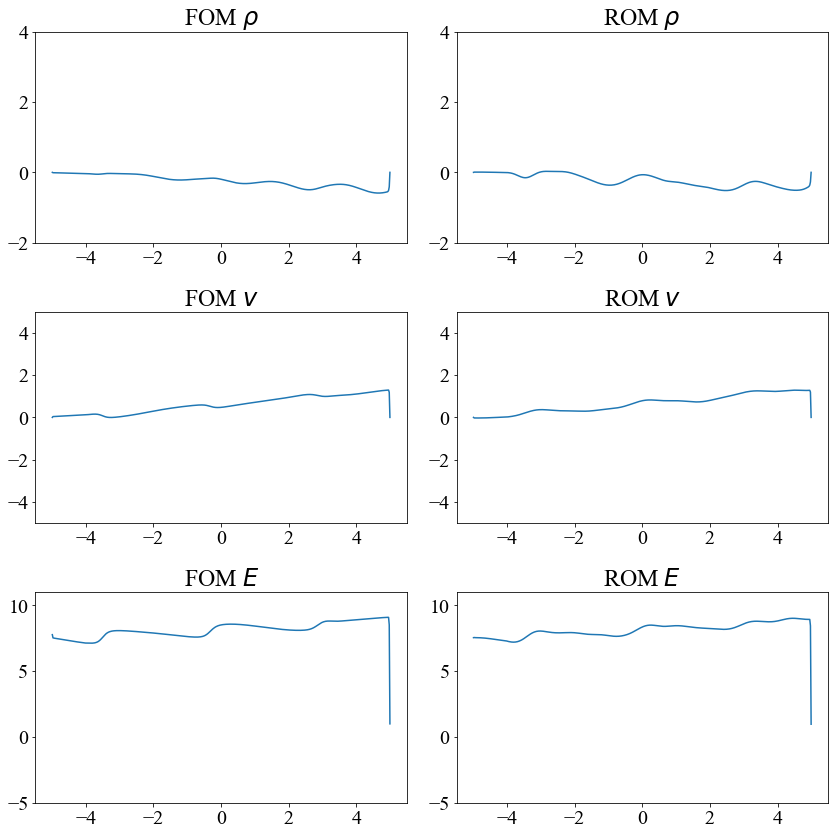

In [9]:
fig, axes = plt.subplots(3,2, figsize=(12,12), tight_layout=True)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
titles = ['FOM $\\rho$', 'ROM $\\rho$', 'FOM $v$', 'ROM $v$',
        'FOM $E$', 'ROM $E$']
lims = [(-2,4), (-2,4), (-5,5), (-5,5), (-5,11), (-5,11)]
lines = []
for i,ax in enumerate(axes.flatten()):
    ax.set_title(titles[i])
    ax.set_ylim(lims[i])
    lines = lines + ax.plot(x,np.zeros(shape[1]))
    

def run(ee_t):

    lines[0].set_ydata(rho_MS[ee_t,:])
    lines[1].set_ydata(pod_rho[ee_t,:])
    lines[2].set_ydata(v_MS[ee_t,:])
    lines[3].set_ydata(pod_v[ee_t,:])
    lines[4].set_ydata(e_MS[ee_t,:])
    lines[5].set_ydata(pod_E[ee_t,:])

    return lines


ani = animation.FuncAnimation(fig, run, shape[2], blit=True, repeat=False)
ani.save('../out/EE/anim_rom.gif', "PillowWriter", fps=5)

### Plot of POD Modes

No handles with labels found to put in legend.


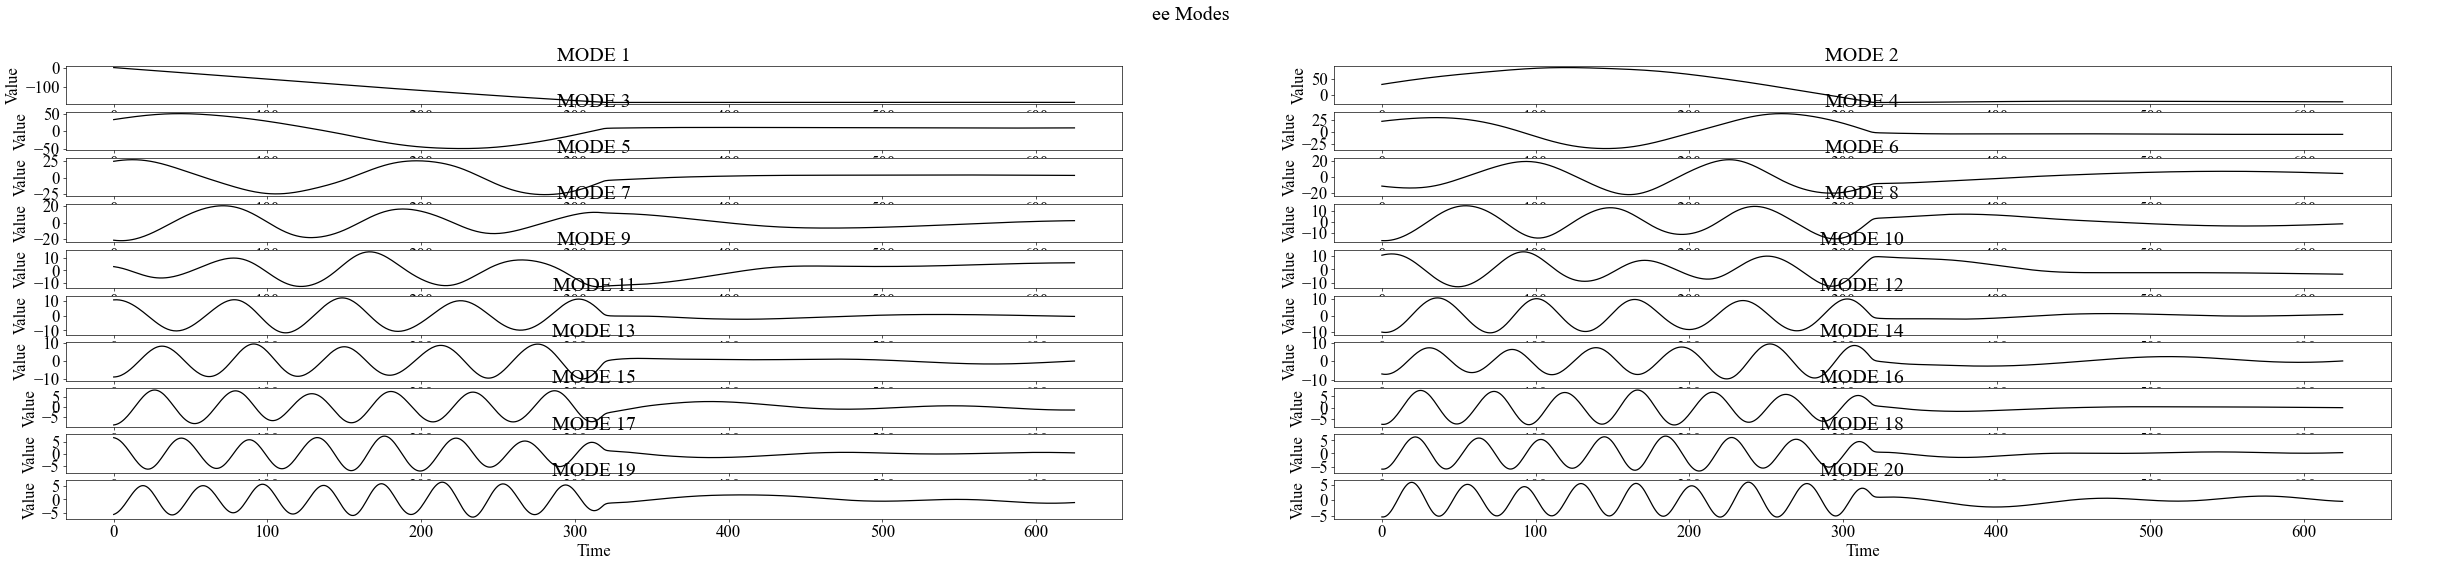

In [10]:
m=2
n = pod_modes//m
plt.figure(figsize=(5*pod_modes//2,10), tight_layout=True, dpi=DPI)
plt.suptitle("ee Modes")
for i in range(pod_modes):
    plt.subplot(pod_modes//2,2,i+1)
    plt.plot(data[:,i], 'k')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title('MODE {}'.format(i+1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10}, frameon=False)
plt.savefig('../out/EE/podModes.pdf', format="pdf", bbox_inches="tight")

### Plot of POD Mode Loss

0.000952773148221961


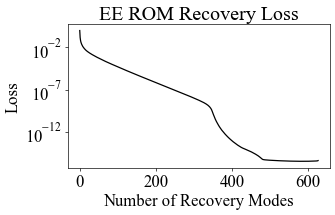

In [11]:
total = sum(eigenvalues)
data = []
cumulative=[1]

for eig in eigenvalues:
    val = eig/total
    data = data + [val]
    cumulative = cumulative + [cumulative[-1]-val]

x = np.arange(0,len(data))
x2 = np.arange(0,len(cumulative))

print(cumulative[39])

#CUMULATIVE PLOT
plt.figure(tight_layout=True, dpi=DPI)
plt.title("EE ROM Recovery Loss")
plt.yscale('log')
plt.plot(x2,cumulative, 'k')
plt.xlabel('Number of Recovery Modes')
plt.ylabel('Loss')
plt.savefig('../out/EE/pod_loss.pdf', format="pdf", bbox_inches="tight")

# Model

In [12]:
seq_win = 10
tr_win = 80
val_win = 100
device = 'cpu'

In [13]:
total_size = data.shape[0] - seq_win
#SEQUENCE DATA
seq_data = np.vstack([[data[t:t + seq_win, :] for t in range(total_size-1)]]).swapaxes(0,1)
seq_label = np.vstack([[data[t+1:t+seq_win+1, :] for t in range(total_size-1)]]).swapaxes(0,1)
print(seq_label.shape)

AttributeError: 'list' object has no attribute 'shape'

(10, 615, 4) (10, 615, 4)


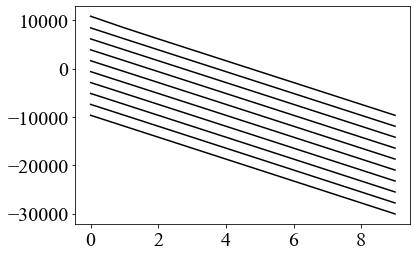

In [ ]:
print(seq_data.shape, seq_label.shape)
plt.plot(seq_data[:,:10,0],'k')
plt.show()

In [ ]:
# training data
train_data = seq_data[:, :tr_win-seq_win, :]
train_label = seq_label[:, :tr_win-seq_win, :]
train_data =  torch.FloatTensor(train_data).to(device)
train_label = torch.FloatTensor(train_label).to(device)
train_times = (torch.ones(train_data.shape[:-1])/train_data.shape[1]).to(device)

torch.Size([10, 70, 4])


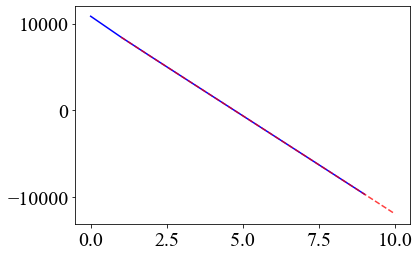

In [ ]:
print(train_label.shape)
plt.plot(train_data[:,0,0], color='b')
plt.plot(np.arange(seq_win+1)[1:],train_label[:,0,0], 'r--', alpha=.75)

torch.Size([10, 10, 4])


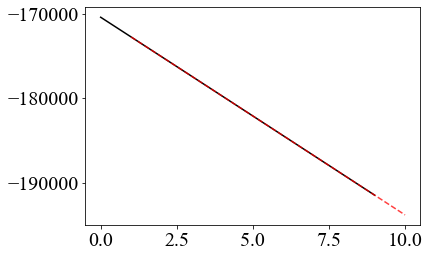

In [ ]:
# validation data
val_data = seq_data[:, tr_win:val_win-seq_win, :]
val_label = seq_label[:, tr_win:val_win-seq_win, :]
val_data =  torch.FloatTensor(val_data).to(device)
print(val_data.shape)
val_label = torch.FloatTensor(val_label).to(device)
val_times = (torch.ones(val_data.shape[:-1])/val_data.shape[1]).to(device)
plt.plot(val_data[:,0,0], color='k')
plt.plot(np.arange(seq_win+1)[1:],val_label[:,0,0], 'r--', alpha=.75)

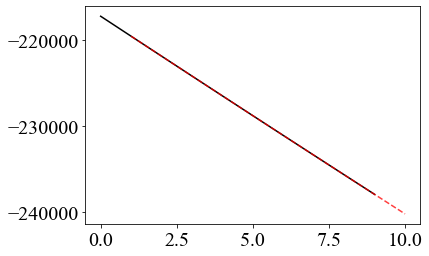

In [ ]:
# validation data
eval_data = seq_data[:, val_win:, :]
eval_label = seq_label[:, val_win:, :]
eval_data =  torch.FloatTensor(eval_data).to(device)
eval_label = torch.FloatTensor(eval_label).to(device)
eval_times = (torch.ones(eval_data.shape[:-1])/eval_data.shape[1]).to(device)
plt.plot(eval_data[:,0,0], color='k')
plt.plot(np.arange(seq_win+1)[1:],eval_label[:,0,0], 'r--', alpha=.75)

In [ ]:
print(train_data.shape, train_times.shape, train_label.shape)
print(val_data.shape, val_label.shape)
print(eval_data.shape, eval_label.shape)

torch.Size([10, 70, 4]) torch.Size([10, 70]) torch.Size([10, 70, 4])
torch.Size([10, 10, 4]) torch.Size([10, 10, 4])
torch.Size([10, 515, 4]) torch.Size([10, 515, 4])


In [ ]:
args = parse_args([])
args.data_dir = '../data/KPP.npz'
args.dataset = 'KPP'
args.out_dir = '../out/IPYNB/'
args.batch_size = 10
args.epochs = 20
args.modes = 4
args.tstart = 0
args.tr_win = 200
args.val_win = 220
args.seq_win = 10


In [ ]:
set_outdir(args.out_dir, args)
model = HBMODEL(args, res=True, cont=True)
DL = SEQ_LOADER(args)
print(DL.train_data.shape, DL.train_times.shape, DL.train_label.shape)
print(DL.valid_data.shape, DL.valid_label.shape)
print(DL.eval_data.shape, DL.eval_label.shape)

[ 0.30074537+0.51713943j  0.30074537-0.51713943j  0.5149443 +0.24335387j
  0.5149443 -0.24335387j  0.57894045+0.j          0.1407328 +0.53665674j
  0.1407328 -0.53665674j -0.05714129+0.5010152j  -0.05714129-0.5010152j
 -0.5402066 +0.j         -0.29628873+0.40486574j -0.29628873-0.40486574j
 -0.44901747+0.11592372j -0.44901747-0.11592372j -0.23332763+0.34914201j
 -0.23332763-0.34914201j -0.3185142 +0.26724645j -0.3185142 -0.26724645j
  0.41668862+0.02525036j  0.41668862-0.02525036j  0.21174586+0.26060763j
  0.21174586-0.26060763j  0.1482407 +0.28789636j  0.1482407 -0.28789636j
  0.24805537+0.04102572j  0.24805537-0.04102572j -0.17119709+0.1703406j
 -0.17119709-0.1703406j  -0.16519289+0.j          0.07020203+0.04622578j
  0.07020203-0.04622578j -0.05159725+0.j        ]
Loading ... 	 Dataset: KPP
Reducing ... 	 Modes: 4
torch.Size([10, 190, 4]) torch.Size([10, 190]) torch.Size([10, 190, 4])
torch.Size([10, 10, 4]) torch.Size([10, 10, 4])
torch.Size([10, 269, 4]) torch.Size([10, 269, 4])


In [ ]:
#LEARNING UTILITIES
gradrec = True
torch.manual_seed(0)
rec = Recorder()
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)
loss_meter_t = RunningAverageMeter()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                factor=args.factor, patience=args.patience, verbose=args.verbose, threshold=1e-5,
                threshold_mode='rel', cooldown=args.cooldown, min_lr=1e-7, eps=1e-08)

Training ...
torch.Size([10, 10, 4])


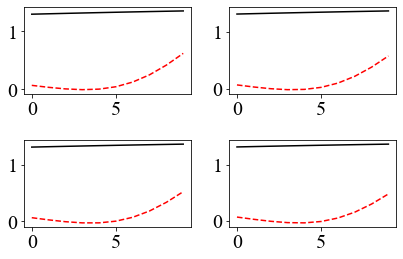

torch.Size([10, 10, 4])


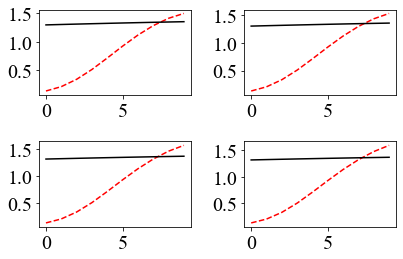

torch.Size([10, 10, 4])


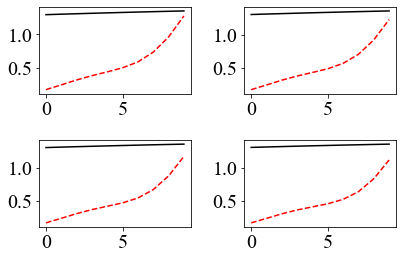

torch.Size([10, 10, 4])


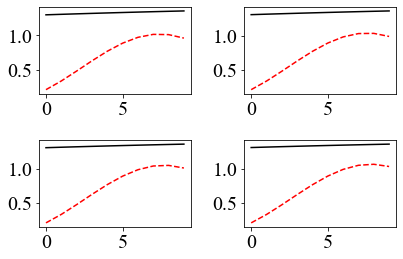

torch.Size([10, 10, 4])


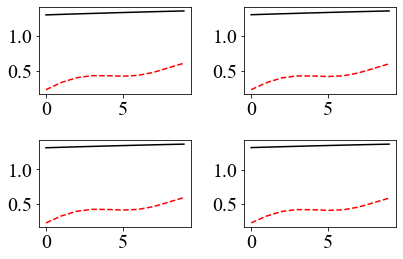

torch.Size([10, 10, 4])


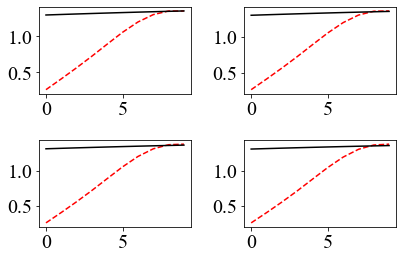

torch.Size([10, 10, 4])


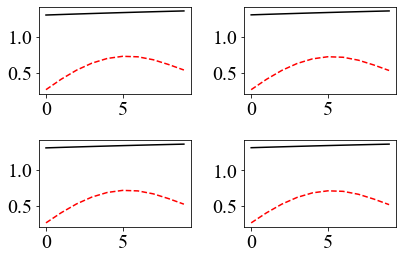

torch.Size([10, 10, 4])


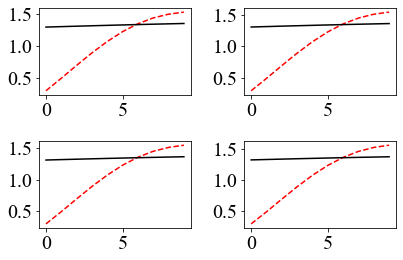

torch.Size([10, 10, 4])


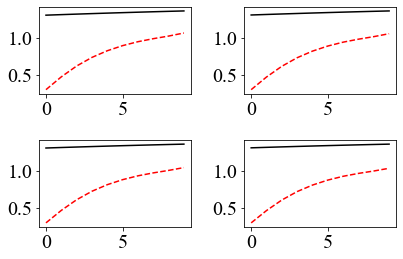

torch.Size([10, 10, 4])


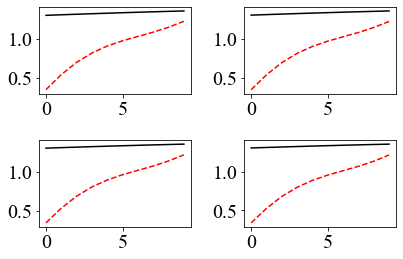

torch.Size([10, 10, 4])


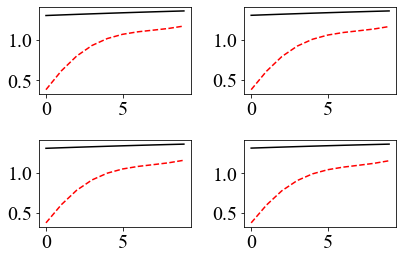

torch.Size([10, 10, 4])


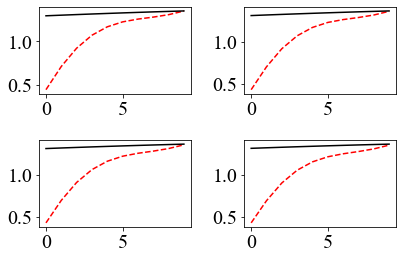

torch.Size([10, 10, 4])


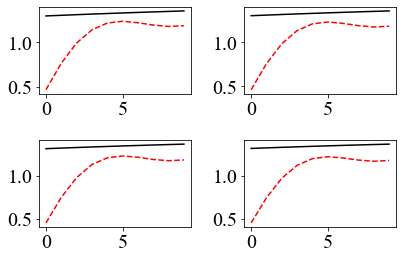

torch.Size([10, 10, 4])


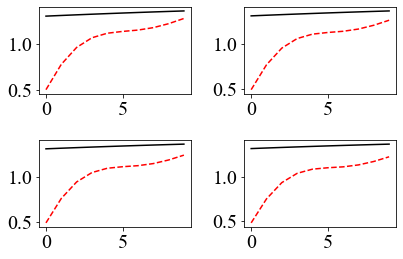

torch.Size([10, 10, 4])


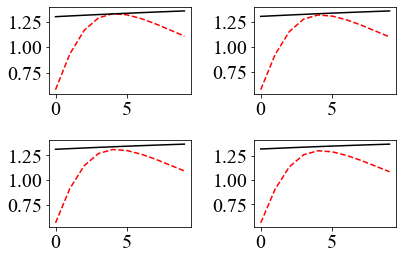

torch.Size([10, 10, 4])


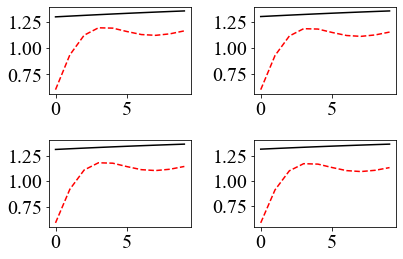

torch.Size([10, 10, 4])


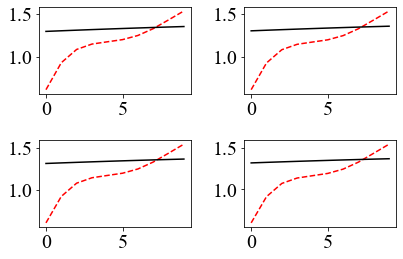

torch.Size([10, 10, 4])


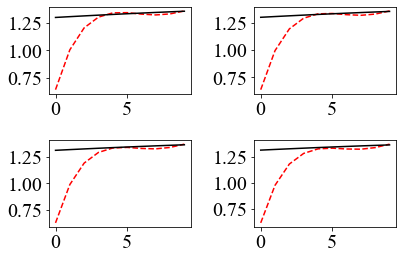

torch.Size([10, 10, 4])


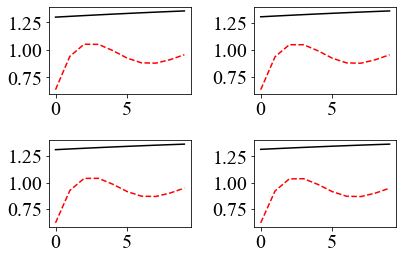

torch.Size([10, 10, 4])


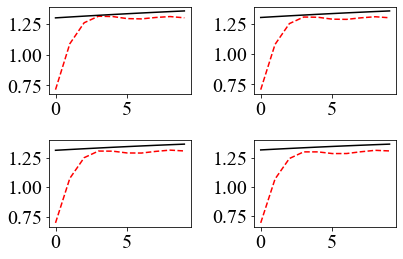

In [ ]:
print("Training ...")
# TRAINING
for epoch in range(args.epochs):

    rec['epoch'] = epoch
    batchsize = args.batch_size
    train_start_time = time.time()

    #SCHEDULER
    for param_group in optimizer.param_groups:
        rec['lr'] = param_group['lr']
    scheduler.step(metrics=loss_meter_t.avg)

    #BATCHING
    for b_n in range(0, DL.train_data.shape[1], batchsize):
        model.cell.nfe = 0
        predict = model(DL.train_times[:, b_n:b_n + batchsize], DL.train_data[:, b_n:b_n + batchsize])
        loss = criteria(predict, DL.train_label[:, b_n:b_n + batchsize])
        loss_meter_t.update(loss.item())
        rec['loss'] = loss

        #BACKPROP
        if gradrec is not None:
            lossf = criteria(predict[-1], DL.train_label[-1, b_n:b_n + batchsize])
            lossf.backward(retain_graph=True)
            vals = model.ode_rnn.h_rnn
            for i in range(len(vals)):
                grad = vals[i].grad
                rec['grad_{}'.format(i)] = 0 if grad is None else torch.norm(grad)
            model.zero_grad()
        model.cell.nfe = 0
        loss.backward()
        rec['backward_nfe'] = model.cell.nfe
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    plt.figure(tight_layout=True)
    print(predict.shape)
    plt.subplot(221)
    plt.plot(predict[:,0,0].detach().numpy(), 'r--', label='Prediction')
    plt.plot(DL.train_label[:, b_n:b_n + batchsize][:,0,0].detach().numpy(), 'k', label='True')
    plt.subplot(222)
    plt.plot(predict[:,1,0].detach().numpy(), 'r--', label='Prediction')
    plt.plot(DL.train_label[:, b_n:b_n + batchsize][:,1,0].detach().numpy(), 'k', label='True')
    plt.subplot(223)
    plt.plot(predict[:,2,0].detach().numpy(), 'r--', label='Prediction')
    plt.plot(DL.train_label[:, b_n:b_n + batchsize][:,2,0].detach().numpy(), 'k', label='True')
    plt.subplot(224)
    plt.plot(predict[:,3,0].detach().numpy(), 'r--', label='Prediction')
    plt.plot(DL.train_label[:, b_n:b_n + batchsize][:,3,0].detach().numpy(), 'k', label='True')

    # plt.legend()
    # plt.title("Epoch {}".format(epoch))
    plt.show()

    rec['train_time'] = time.time() - train_start_time

    #VALIDATION
    if epoch == 0 or (epoch + 1) % 1 == 0:
        model.cell.nfe = 0
        predict = model(DL.valid_times, DL.valid_data)
        vloss = criteria(predict, DL.valid_label)
        rec['va_nfe'] = model.cell.nfe
        rec['va_loss'] = vloss

    #TEST
    if epoch == 0 or (epoch + 1) % 5 == 0:
        model.cell.nfe = 0
        predict = model(DL.eval_times, DL.eval_data)
        sloss = criteria(predict, DL.eval_label)
        sloss = sloss.detach().cpu().numpy()
        rec['ts_nfe'] = model.cell.nfe
        rec['ts_loss'] = sloss

    #OUTPUT
    rec.capture(verbose=False)
    if (epoch + 1) % 5 == 0:
        torch.save(model, args.out_dir+'/pth/{}.mdl'.format(args.model))
        rec.writecsv(args.out_dir+'/pth/{}.csv'.format(args.model))


In [ ]:
args.verbose = True

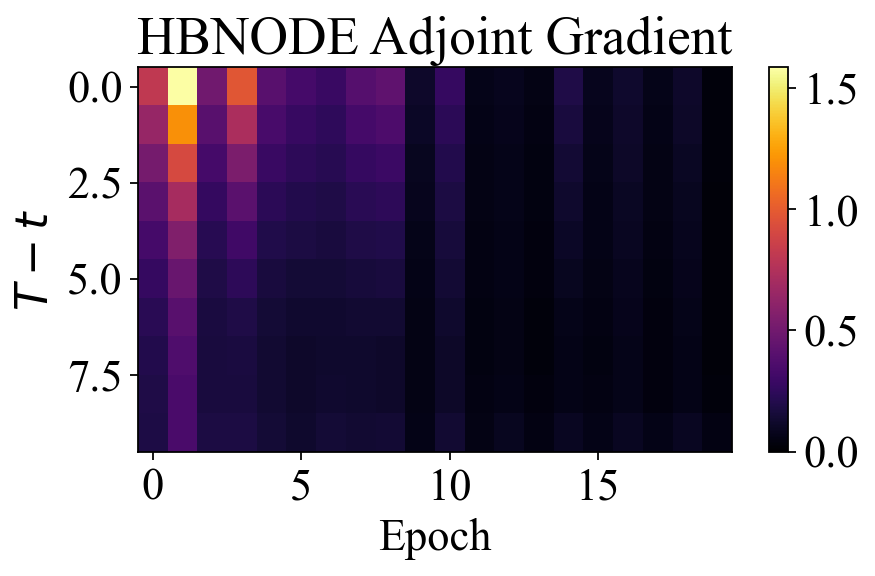

1

In [ ]:
plot_AdjGrad(args.out_dir+'/pth/{}.csv'.format(args.model),args)

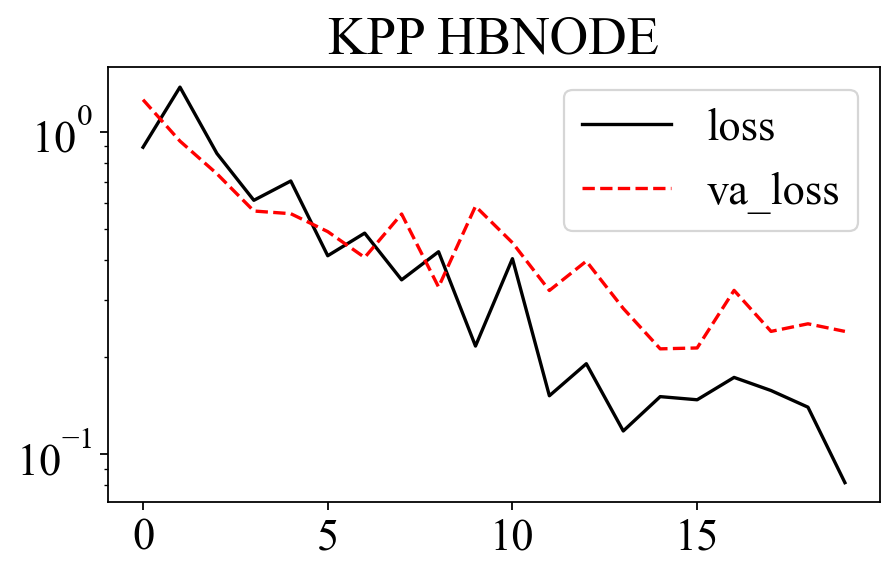

1

In [ ]:
plot_Loss(args.out_dir+'/pth/{}.csv'.format(args.model),args)

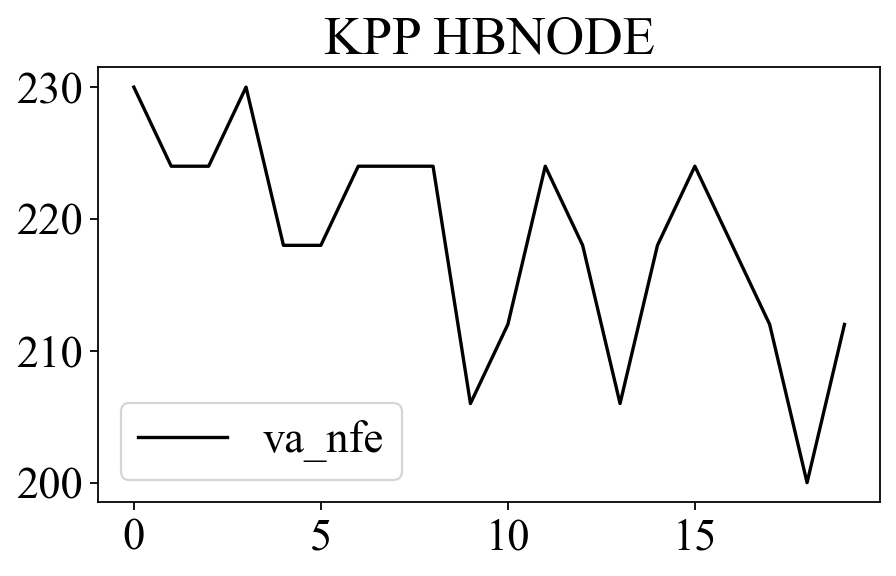

1

In [ ]:
plot_NFE(args.out_dir+'/pth/{}.csv'.format(args.model),args)


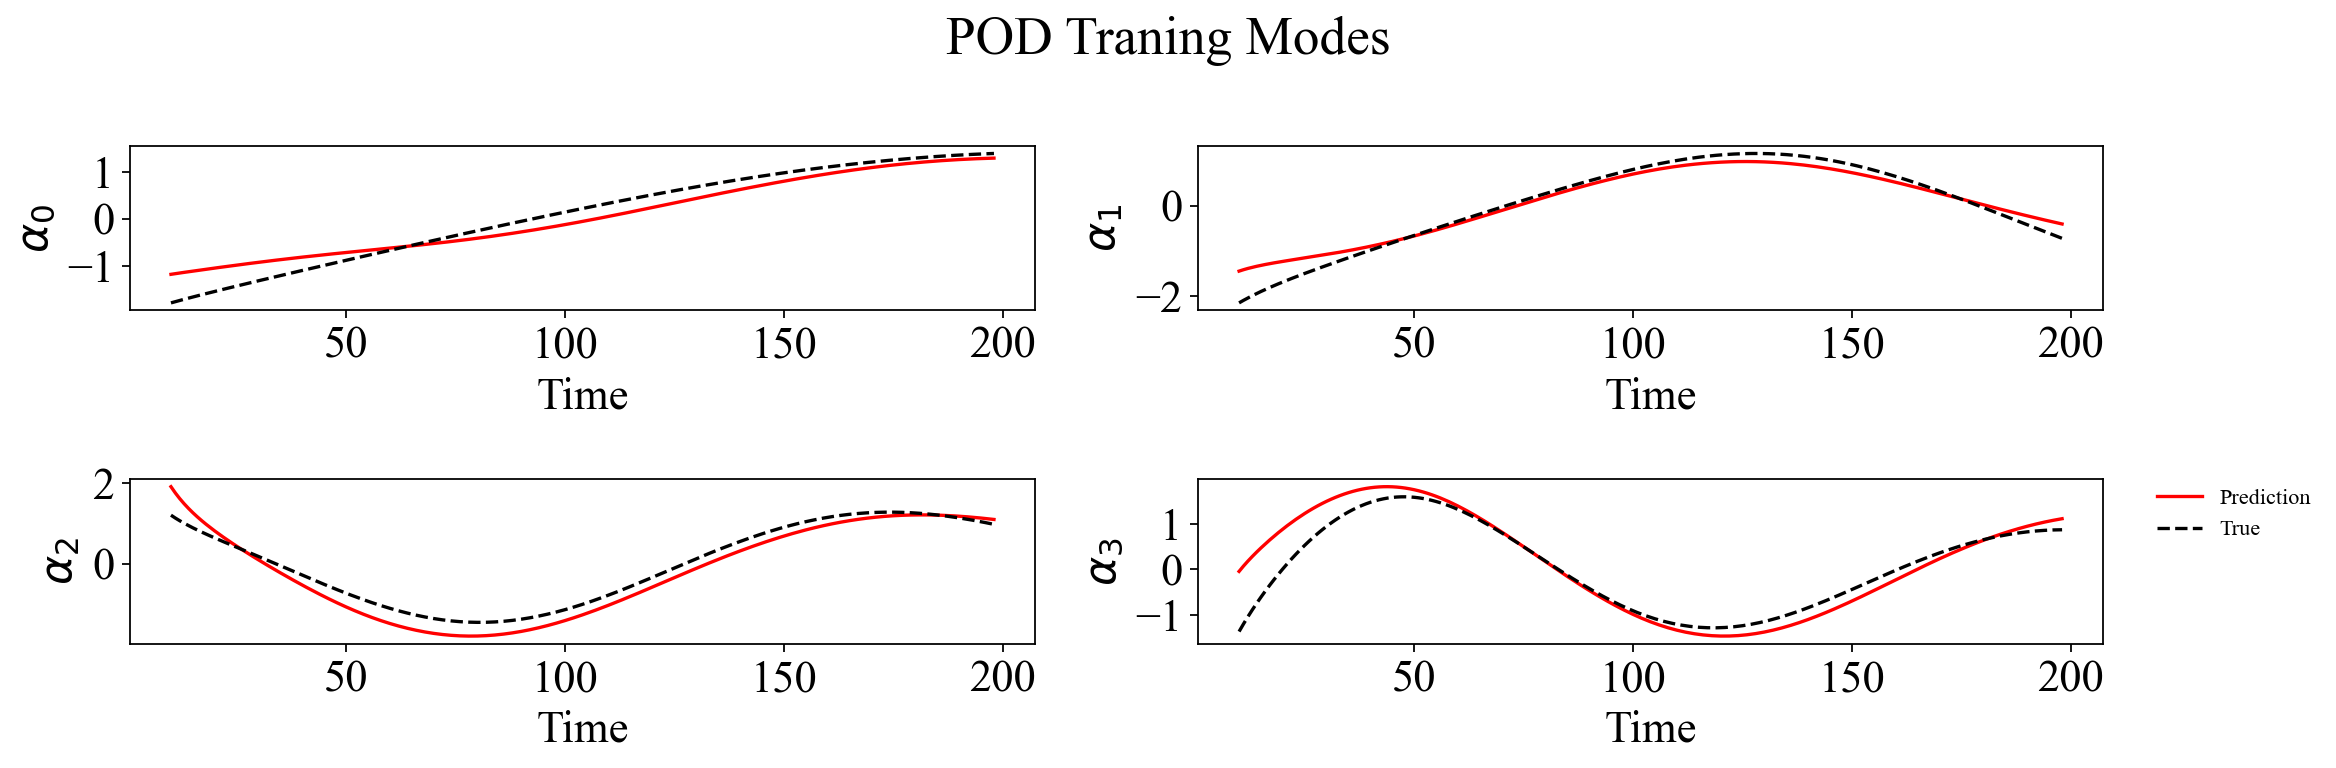

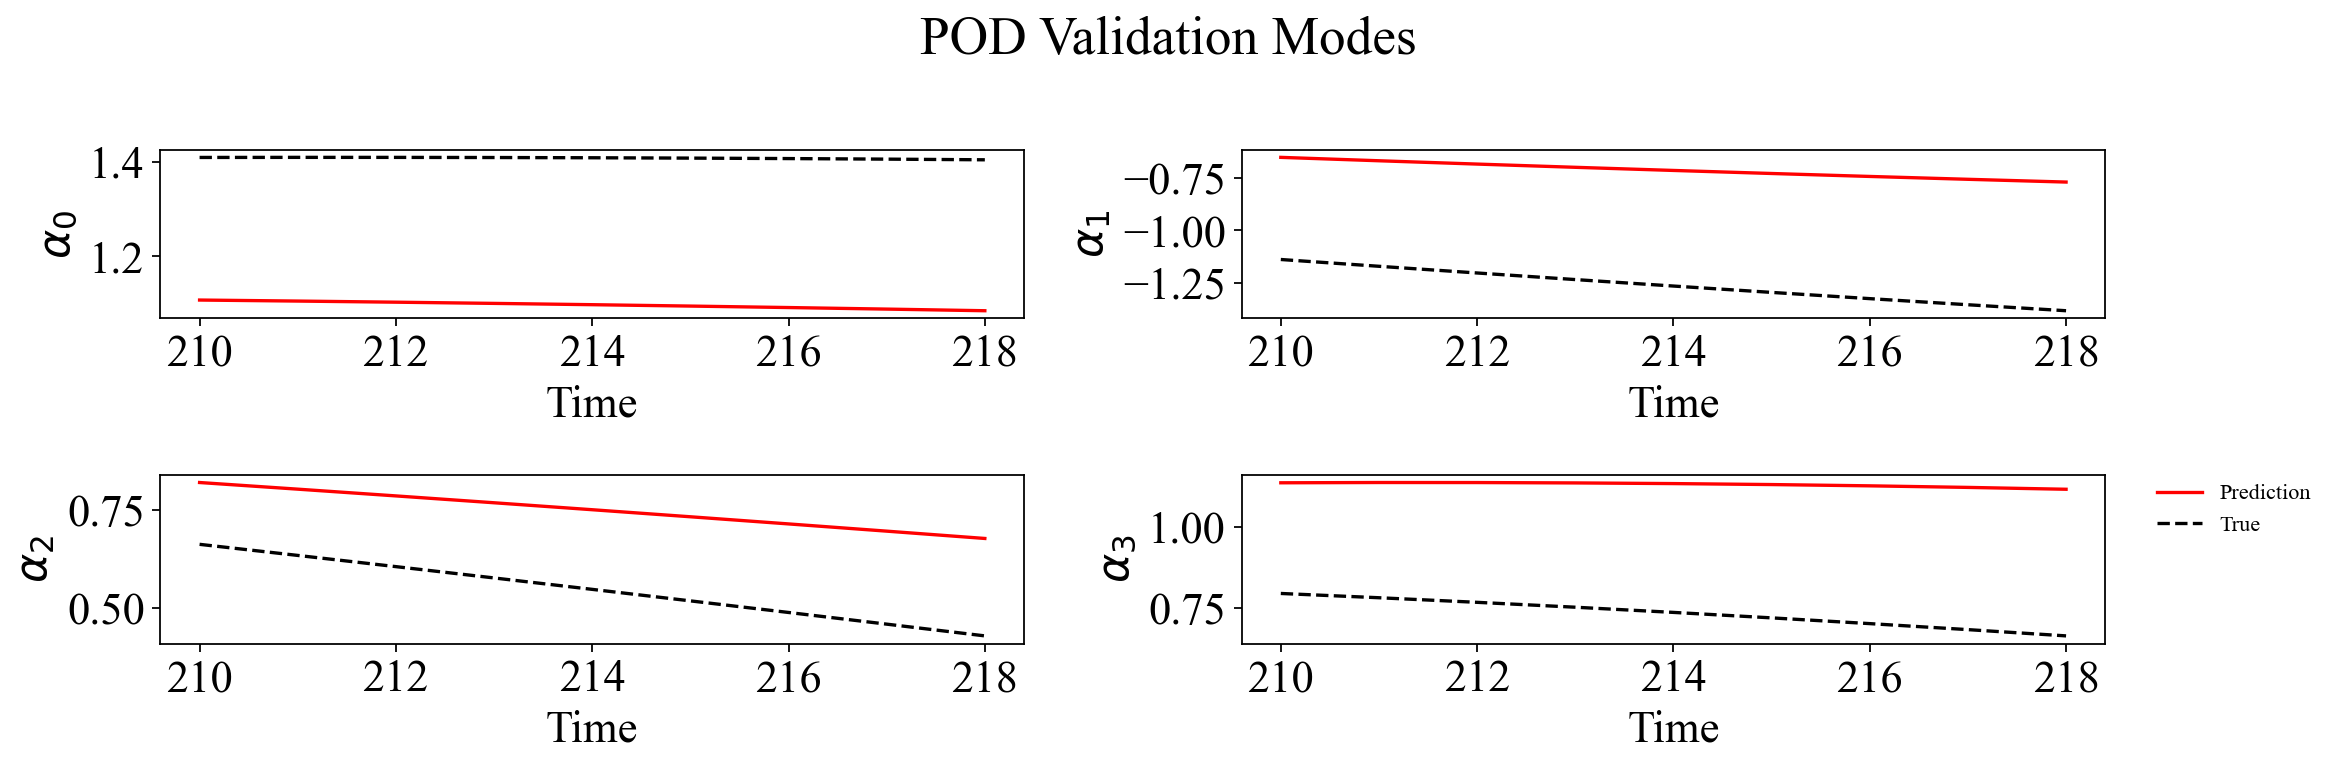

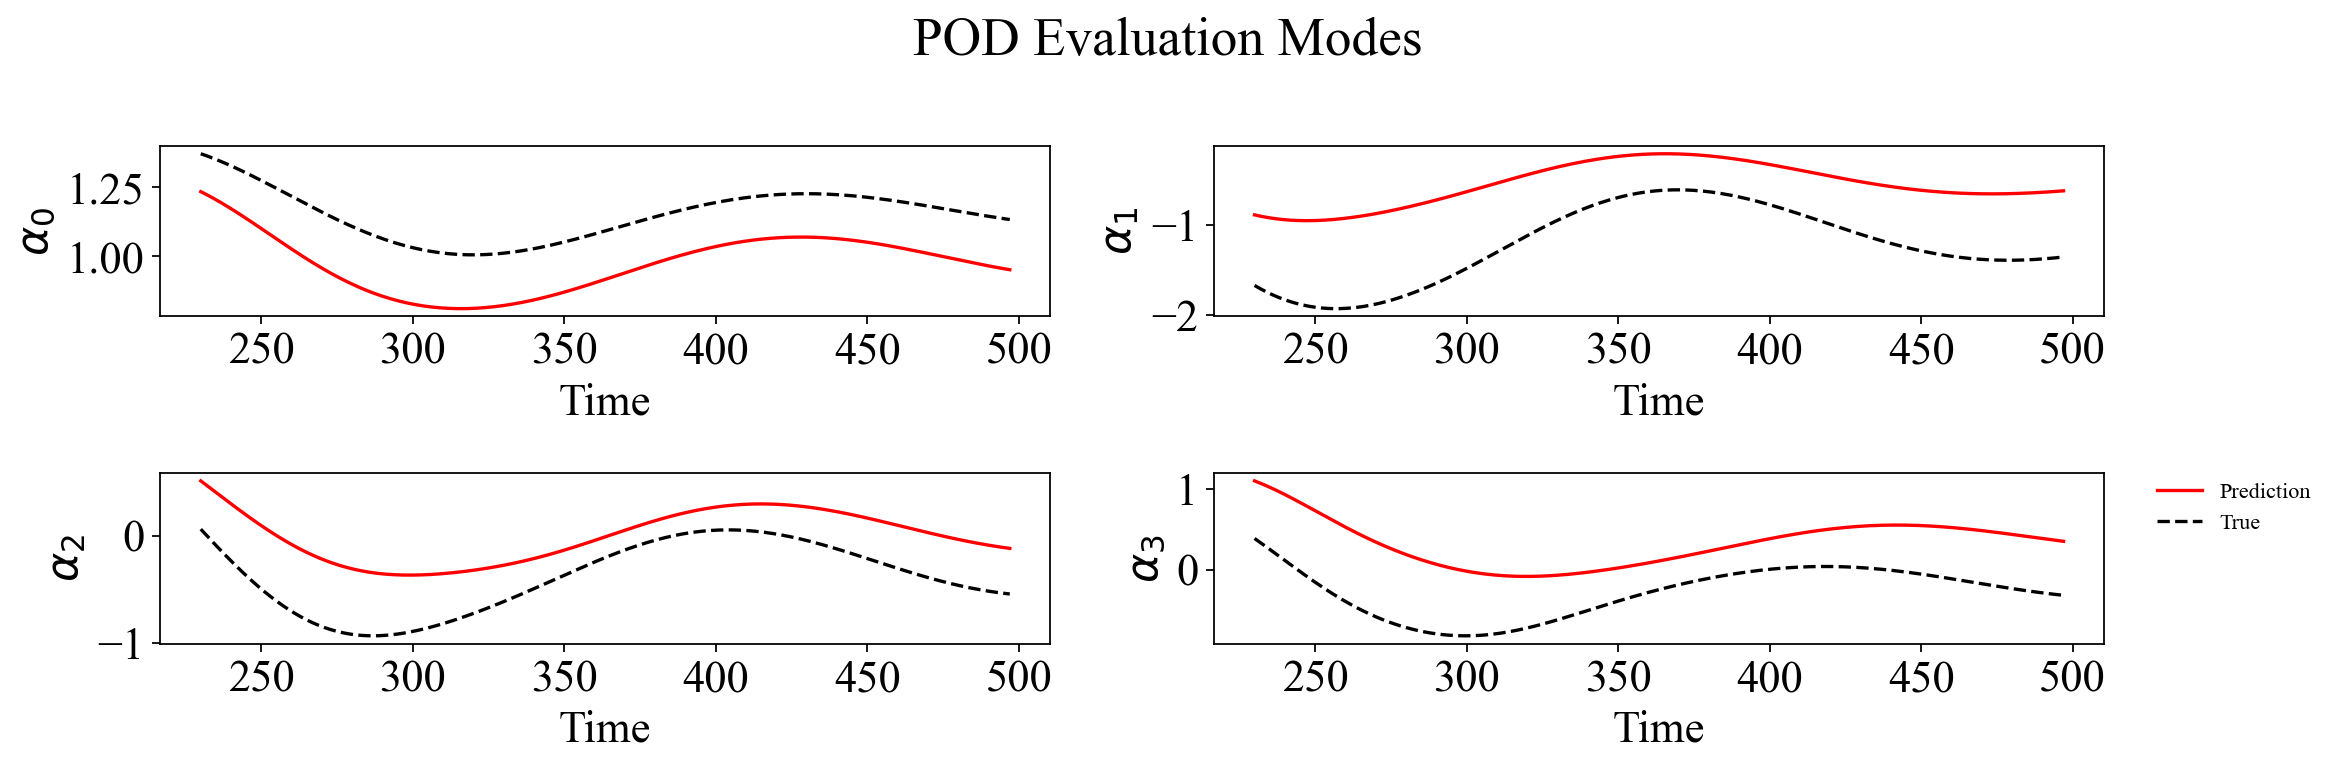

1

In [ ]:
plot_Modes(DL, model, args)

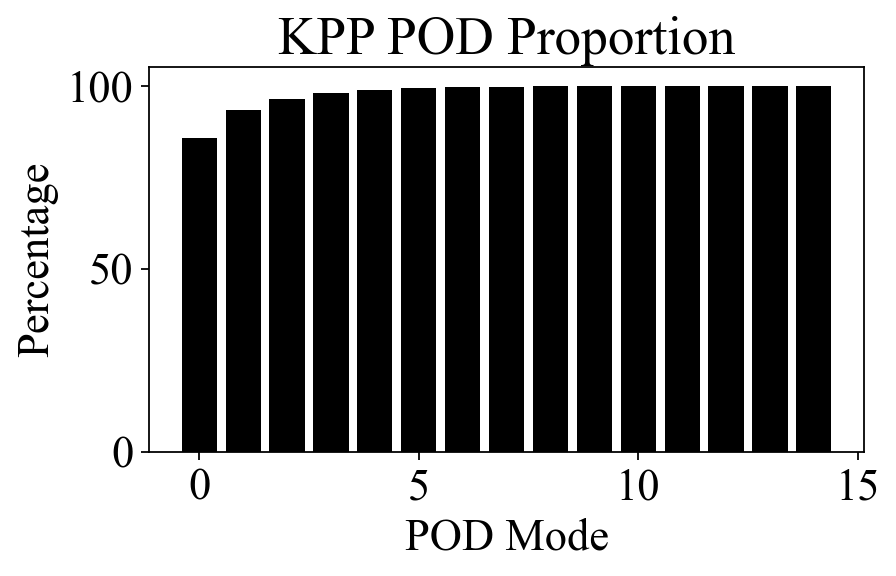

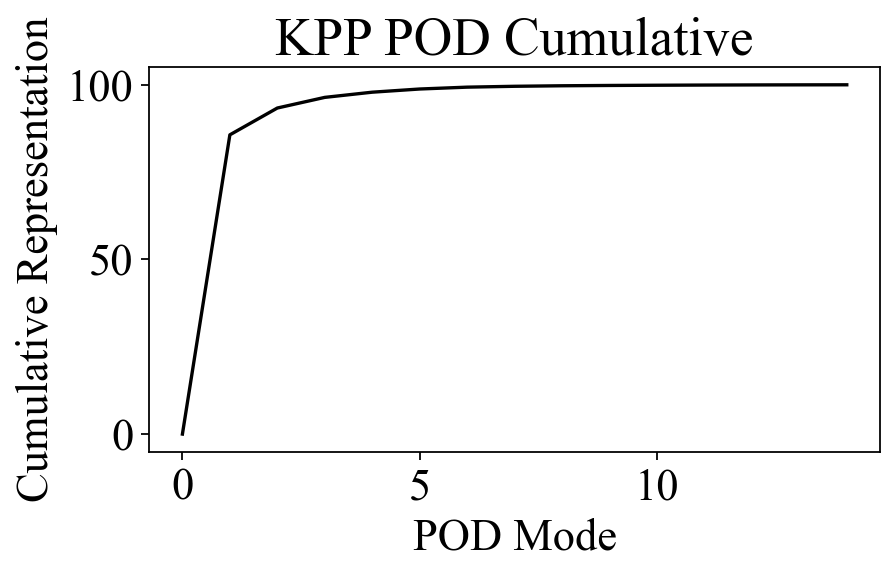

1

In [ ]:
plot_PODecay(DL,args)